## Self-Driving Car - Lane Lines & Vehicle Detection 

Import section for our used libraries

In [20]:
import sklearn
import glob
import pickle
import os
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage.measurements import label
from scipy import misc
import keras
print('keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split
# from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.transform import resize

# Show plots inline notebook
%matplotlib inline

keras: 1.2.0


Import the dataset containing cars and non-cars images with a resolution of 64x64 pixel

In [2]:
cars = glob.glob("../data/udacity_vehicle_lane/vehicles/*/*.png")
non_cars = glob.glob("../data/udacity_vehicle_lane/non-vehicles/*/*.png")

# Read X Vector
X = []
for file in cars:    
    X.append(skimage.io.imread(file))
for file in non_cars:    
    X.append(skimage.io.imread(file))
X = np.array(X)

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])

# Split train and validation dataset with 10%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=63)

# Show messages
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

print('Y_train shape:', Y_train.shape)
print(Y_train.shape[0], 'train samples')
print(Y_test.shape[0], 'test samples')

('X_train shape:', (15984, 64, 64, 3))
(15984, 'train samples')
(1776, 'test samples')
('Y_train shape:', (15984,))
(15984, 'train samples')
(1776, 'test samples')


Explore the dataset by showing 40 random images from the training data

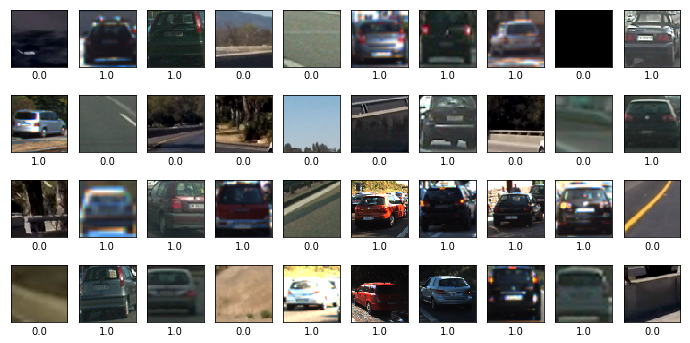

In [3]:
def showRandomImages():
    fig = plt.figure(figsize=(12, 6))
    for i in range(0, 40):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(4,10,i+1)
        axis.set_xlabel(Y_train[number])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        axis.imshow(X_train[number])
    plt.show()

showRandomImages()

Show a distribution to see if the dataset is balanced or unbalanced

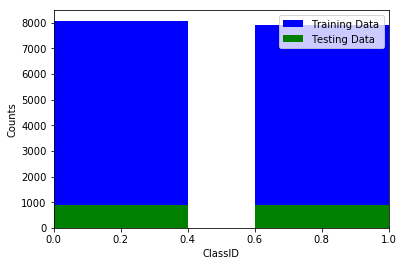

In [4]:
def showDistribution():
    _, training_counts = np.unique(Y_train, return_counts = True)
    _, test_counts = np.unique(Y_test, return_counts = True)
    plt.bar( np.arange( 2 ), training_counts,   color='b', label='Training Data')
    plt.bar( np.arange( 2 ), test_counts,  color='g', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([0, 1])
    plt.legend()
    plt.show()
    
showDistribution()

Create the all-convolutional network and add a flatten layer at the end for training

In [37]:
def create_model(input_shape=(64,64,3)):
    # Inspired from https://github.com/antevis/CarND-Project5-Vehicle_Detection_and_Tracking/blob/master/model.py
    model = Sequential()
    # Center and normalize our data
    model.add(Lambda(lambda x: x / 255., input_shape=input_shape, output_shape=input_shape))
    # 1st conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(16, 3, 3, activation='relu', name='cv0',input_shape=input_shape, border_mode="same", dim_ordering='tf'))  
    model.add(Dropout(0.5))
    # 2nd conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(32, 3, 3, activation='relu', name='cv1',border_mode="same", dim_ordering='tf'))
    model.add(Dropout(0.5))
    # 3rd conv layer with 128 filter, 3x3 each, 8x8 pooling and dropout
    model.add(Convolution2D(64, 3, 3, activation='relu', name='cv2',border_mode="same", dim_ordering='tf'))
    model.add(MaxPooling2D(pool_size=(8,8), dim_ordering='tf'))
    model.add(Dropout(0.5)) 
    model.add(Convolution2D(1,8,8, activation='sigmoid', name='fcn',dim_ordering='tf'))
    
    return model

In [55]:
def create_model(input_shape=(64,64,3)):
    # Inspired from https://github.com/maxritter/SDC-Vehicle-Lane-Detection
    model = Sequential()
    # Center and normalize our data
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    # 1st conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same", dim_ordering='tf'))  
    model.add(Dropout(0.5))
    # 2nd conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2',border_mode="same", dim_ordering='tf'))
    model.add(Dropout(0.5))
    # 3rd conv layer with 128 filter, 3x3 each, 8x8 pooling and dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3',border_mode="same", dim_ordering='tf'))
    model.add(MaxPooling2D(pool_size=(8,8), dim_ordering='tf'))
    model.add(Dropout(0.5))
    # This acts like a 128 neuron dense layer
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1", dim_ordering='tf')) 
    model.add(Dropout(0.5))
    # This is like a 1 neuron dense layer with tanh [-1, 1]
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh", dim_ordering='tf')) 
    
    return model

In [56]:
model = create_model()
model.summary()
model.add(Flatten())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_19 (Lambda)               (None, 64, 64, 3)     0           lambda_input_19[0][0]            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 64, 128)   3584        lambda_19[0][0]                  
____________________________________________________________________________________________________
dropout_64 (Dropout)             (None, 64, 64, 128)   0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 64, 64, 128)   147584      dropout_64[0][0]                 
___________________________________________________________________________________________

Train the network using the dataset, ONLY DO THIS ONCE

Train on 15984 samples, validate on 1776 samples
Epoch 1/20
185s - loss: 0.1488 - acc: 0.7936 - val_loss: 0.0646 - val_acc: 0.9054
Epoch 2/20
185s - loss: 0.0444 - acc: 0.9423 - val_loss: 0.0218 - val_acc: 0.9735
Epoch 3/20
185s - loss: 0.0294 - acc: 0.9617 - val_loss: 0.0113 - val_acc: 0.9870
Epoch 4/20
185s - loss: 0.0189 - acc: 0.9764 - val_loss: 0.0111 - val_acc: 0.9842
Epoch 5/20
185s - loss: 0.0165 - acc: 0.9792 - val_loss: 0.0119 - val_acc: 0.9870
Epoch 6/20
185s - loss: 0.0133 - acc: 0.9828 - val_loss: 0.0089 - val_acc: 0.9904
Epoch 7/20
185s - loss: 0.0116 - acc: 0.9851 - val_loss: 0.0063 - val_acc: 0.9927
Epoch 8/20
185s - loss: 0.0095 - acc: 0.9886 - val_loss: 0.0089 - val_acc: 0.9887
Epoch 9/20
185s - loss: 0.0095 - acc: 0.9879 - val_loss: 0.0323 - val_acc: 0.9617
Epoch 10/20
185s - loss: 0.0090 - acc: 0.9895 - val_loss: 0.0054 - val_acc: 0.9944
Epoch 11/20
185s - loss: 0.0081 - acc: 0.9902 - val_loss: 0.0088 - val_acc: 0.9904
Epoch 12/20
185s - loss: 0.0077 - acc: 0.9909 -

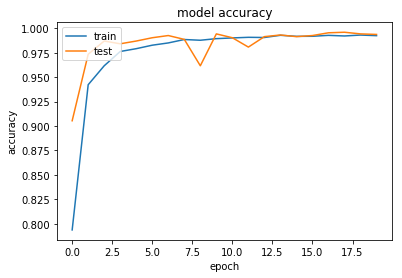

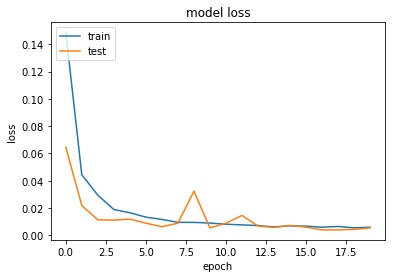

In [8]:
# Plot the results of the training
def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=2, validation_data=(X_test, Y_test))

plot_results(history)

model.save_weights('../models/model.h5')

Load the weights from the trained network

In [57]:
# Load the fine-tuned for the final network
model.load_weights('../models/gpu_trained_model_maxritter.h5')
print("Weights loaded!")

Weights loaded!


Initialize the weights for the network and try it on a sample image

NN Prediction: NO CAR with value 0.000339791
Ground-truth: NO CAR with value 0.0


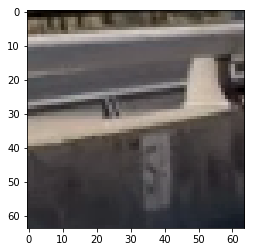

In [58]:
# Pick a random image from the test set
rand = np.random.randint(X_test.shape[0])
plt.imshow(X_test[rand])

# Predict the correct label
sample = np.reshape(X_test[rand], (1, 64,64,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
prediction = prediction[0][0]

# Check if the prediction is a car or a non-car
if prediction >= 0.5:
    print("NN Prediction: CAR with value " + str(prediction))
else:
    print("NN Prediction: NO CAR with value " + str(prediction))
    
# Compare with the ground-truth
truth = Y_test[rand]
if truth == 1:
    print("Ground-truth: CAR with value " + str(truth))
else:
    print("Ground-truth: NO CAR with value " + str(truth))

We load a sample image to test our neural network on

(768, 1024, 3)
(720, 1024, 3)


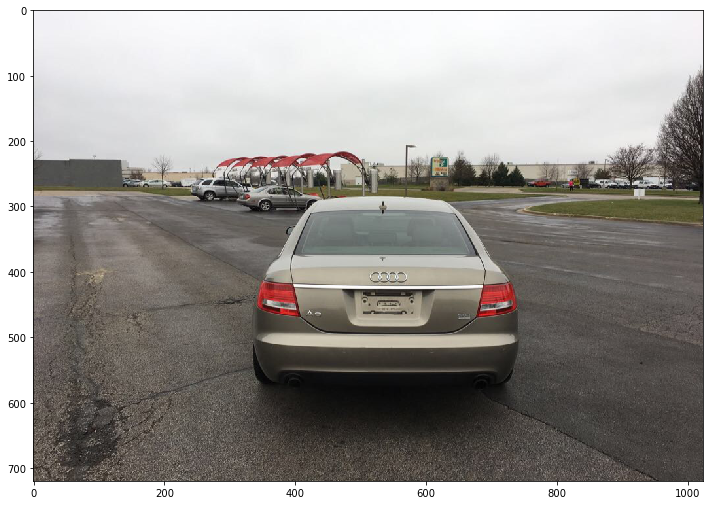

In [62]:
# Load a specific sample image
img = skimage.io.imread('../data/udacity_vehicle_lane/test_images/test8.jpg')
print img.shape
img = misc.imresize(img, (min(720, img.shape[0]), min(1280, img.shape[1]), min(3, img.shape[2])))
print img.shape
# Display it
fig = plt.figure(figsize=(12,20))
plt.imshow(img)

Search for cars in the image using the neural network, create bounding boxes for each hit

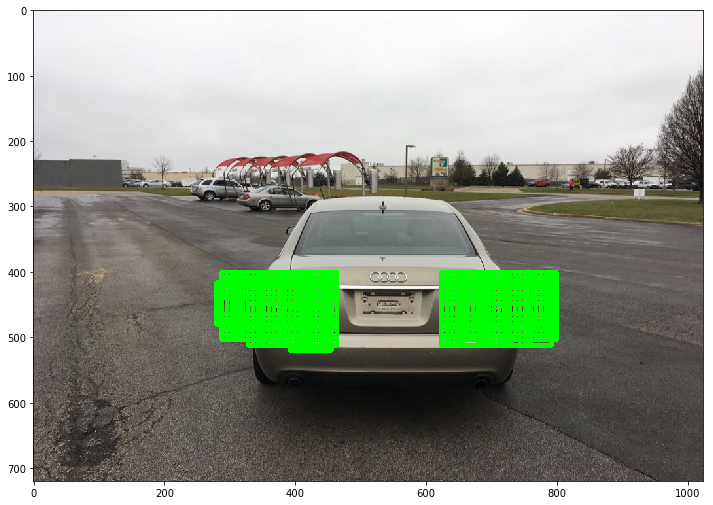

In [64]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def search_cars(img):
    # We crop the image to 440-660px in the vertical direction
    cropped = img[400:660, 0:1280]
    heat = heatmodel.predict(cropped.reshape(1,cropped.shape[0],cropped.shape[1],cropped.shape[2]))
    # This finds us rectangles that are interesting
    xx, yy = np.meshgrid(np.arange(heat.shape[2]),np.arange(heat.shape[1]))
    x = (xx[heat[0,:,:,0]>0.9999999])
    y = (yy[heat[0,:,:,0]>0.9999999])
    hot_windows = []
    # We save those rects in a list
    for i,j in zip(x,y):
        hot_windows.append(((i*8,400 + j*8), (i*8+64,400 +j*8+64)))
    return hot_windows

# Init a version of our network with another resolution without the flatten layer
heatmodel = create_model((260, 1024, 3))
# heatmodel = create_model((260, 1024, 3))
# Load the weights
heatmodel.load_weights('../models/gpu_trained_model_maxritter.h5')

# Search for our windows
hot_windows = search_cars(img)

# Draw the found boxes on the test image
window_img = draw_boxes(img, hot_windows, (0, 255, 0), 6)                    

# Show the image with the windows on top
fig = plt.figure(figsize=(12,20))
plt.imshow(window_img)

Create a heatmap out of the found bounding boxes, threshold it and find the final bounding boxes

(2, 'cars found')


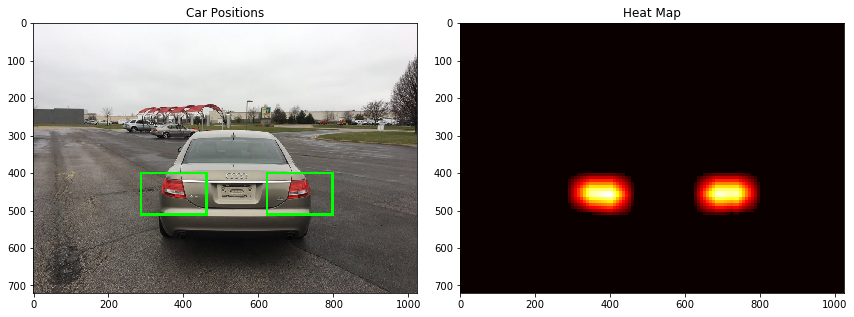

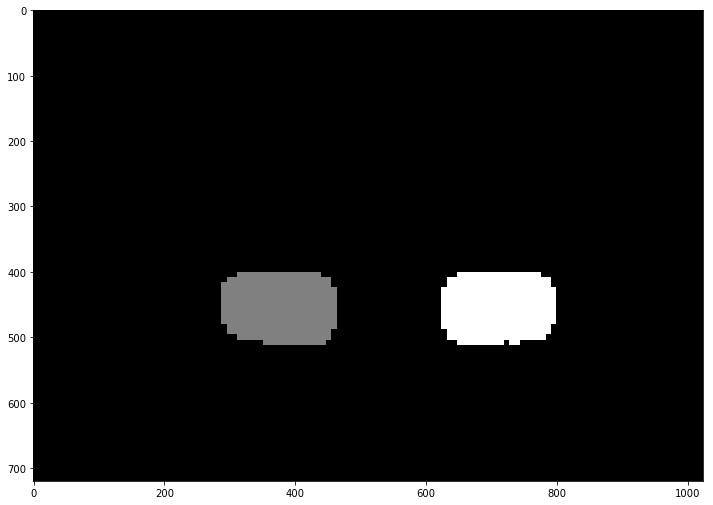

In [65]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# Create image for the heat similar to one shown above 
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
boxes = label(heatmap)

# Create the final image
draw_img = draw_labeled_bboxes(np.copy(img), boxes)

# Show the car positions and the heat map with threshold applied
fig = plt.figure(figsize=(12,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Print information about the cars found
print(boxes[1], 'cars found')
fig = plt.figure(figsize=(12,20))
plt.imshow(boxes[0], cmap='gray')